In [1]:
import h5py
import inspect
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
from collections import OrderedDict
from collections import defaultdict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Inspect Available GPUs

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


In [3]:
print("Cuda is available:", torch.cuda.is_available())
print("Cuda device count:", torch.cuda.device_count())

Cuda is available: True
Cuda device count: 2


## Create Datasets

In [4]:
PATH_TO_TRAIN = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_train_features.hdf5"
PATH_TO_VAL = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_val_features.hdf5"
PATH_TO_TEST = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/data_splits/custom_splits/triplenet_features/triplenet_test_features.hdf5"

In [45]:
class MILDataset(Dataset):
    
    def __init__(self, hdf5_path: str, transform=None):
        self.hdf5_path = hdf5_path
        self.h5data = h5py.File(self.hdf5_path, "r")
        self.cores = list(self.h5data.keys())
        self.transform = transform
        
    def __len__(self):
        return len(self.cores)
    
    def __getitem__(self, idx):
        patient_id = self.cores[idx]
        patches = self.h5data[patient_id][()]
        label = self.h5data[patient_id].attrs["y"]
        if self.transform:
            patches = self.transform(patches)
        return torch.tensor(patches), torch.tensor(int(label))

class NaiveDataset(Dataset):
    def __init__(self, hdf5_path: str, transform=None):

        self.hdf5_path = hdf5_path
        self.h5data = h5py.File(self.hdf5_path, "r")
        self.cores = list(self.h5data.keys())
        
        self.lengths = [len(self.h5data[i]) for i in self.cores]

        self.transform = transform

    def __len__(self):
        return sum(self.lengths)

    def __getitem__(self, idx):

        core_idx = 0
        for l in self.lengths:
            if idx - self.lengths[core_idx] < 0:
                break
            idx -= self.lengths[core_idx]
            core_idx += 1
        
        
        core_id = self.cores[core_idx]
        patch: np.ndarray = self.h5data[core_id][()][idx]
        label = self.h5data[core_id].attrs["y"]
        
        if self.transform:
            patch = self.transform(patch)

        return patch, torch.tensor(int(label))

In [46]:
# train_dataset = NaiveDataset(PATH_TO_TRAIN)
# val_dataset = NaiveDataset(PATH_TO_VAL)
# test_dataset = NaiveDataset(PATH_TO_TEST)

train_dataset = MILDataset(PATH_TO_TRAIN)
val_dataset = MILDataset(PATH_TO_VAL)
test_dataset = MILDataset(PATH_TO_TEST)

## Create Dataloaders

In [49]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=True)

In [50]:
# Output the label distribution in the train_dataloader
label_counts = defaultdict(int)
for (x,y) in train_dataloader:
    label_counts[y.item()] += 1
label_counts

defaultdict(int,
            {1: 131, 0: 370, 3: 59, 7: 43, 8: 4, 4: 75, 6: 59, 5: 21, 2: 10})

## Create Linear Layer Above Feature Extractor

In [51]:
class LinearLayer(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(256*3, num_classes)
    
    def forward(self, x):
        out = self.linear(x)
        return out

model = LinearLayer(9)

## Define Optimizer and Loss Criterion

In [52]:
# learning_rate = 1e-2
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

weights = [0.0058, 0.0156, 0.1861, 0.0357, 0.0291, 0.0994, 0.0341, 0.0542, 0.5400]

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).cuda())

## Define Training Loop

In [57]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        i = 0
        for x, y in tqdm(batches):
            optimizer.zero_grad()
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            # x, y = gpu(x), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            loss = criterion(aggregated_scores, y)
            # loss = criterion(scores, y)
            loss.backward()
            optimizer.step()
            _,preds = torch.max(aggregated_scores, 1)
            # _,preds = torch.max(scores, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
            i += 1
        print(f"Completed {i} iterations in epoch")
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    
    train_accuracy_history = [i.cpu() for i in train_accuracy_history]
    val_accuracy_history = [i.cpu() for i in val_accuracy_history]
    
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in tqdm(batches):
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            # x, y = gpu(x), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            loss = criterion(aggregated_scores, y)
            # loss = criterion(scores, y)
            _, preds = torch.max(aggregated_scores, 1)
            # _, preds = torch.max(scores, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))

In [58]:
%%time
epochs = 10
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=epochs)

Epoch: 0


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 1 Training Loss: 1.5032 Got 375 / 772 correct. Acc: 48.58%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 1 Validation Loss: 1.8660 Got 106 / 276 correct 38.41%
Epoch: 1


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 2 Training Loss: 1.5080 Got 375 / 772 correct. Acc: 48.58%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 2 Validation Loss: 1.8855 Got 111 / 276 correct 40.22%
Epoch: 2


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 3 Training Loss: 1.5043 Got 375 / 772 correct. Acc: 48.58%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 3 Validation Loss: 1.8624 Got 110 / 276 correct 39.86%
Epoch: 3


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 4 Training Loss: 1.5005 Got 380 / 772 correct. Acc: 49.22%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 4 Validation Loss: 1.8829 Got 110 / 276 correct 39.86%
Epoch: 4


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 5 Training Loss: 1.4940 Got 373 / 772 correct. Acc: 48.32%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 5 Validation Loss: 1.8426 Got 111 / 276 correct 40.22%
Epoch: 5


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 6 Training Loss: 1.4935 Got 373 / 772 correct. Acc: 48.32%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 6 Validation Loss: 1.9048 Got 110 / 276 correct 39.86%
Epoch: 6


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 7 Training Loss: 1.4926 Got 376 / 772 correct. Acc: 48.70%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 7 Validation Loss: 1.8712 Got 110 / 276 correct 39.86%
Epoch: 7


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 8 Training Loss: 1.4854 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 8 Validation Loss: 1.8970 Got 110 / 276 correct 39.86%
Epoch: 8


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 9 Training Loss: 1.4838 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 9 Validation Loss: 1.9061 Got 110 / 276 correct 39.86%
Epoch: 9


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 10 Training Loss: 1.4759 Got 376 / 772 correct. Acc: 48.70%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 10 Validation Loss: 1.8693 Got 106 / 276 correct 38.41%
CPU times: user 23.2 s, sys: 4.11 s, total: 27.3 s
Wall time: 54.8 s


In [59]:
def plot(l, l_v):
    plt.plot([i for i in range(len(l))], l, 'r', [i for i in range(len(l_v))], l_v, 'b')

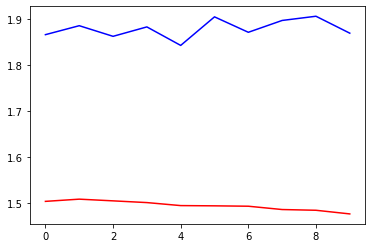

In [60]:
plot(LOSS, LOSS_V)

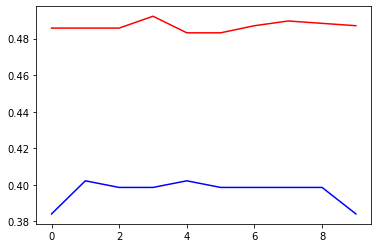

In [61]:
ACC = [i.cpu() for i in ACC]
ACC_V = [i.cpu() for i in ACC_V]

plot(ACC, ACC_V)

In [62]:
PATH = "triplenet_model.dat"
torch.save(model, PATH)
print("Successfully saved model!")

Successfully saved model!


In [63]:
# Print out the model parameters after training.
for name, param in model.named_parameters():
    print(param)

Parameter containing:
tensor([[ 0.3003,  0.0120,  0.1077,  ...,  0.0441,  0.0222, -0.1945],
        [ 0.0123,  0.2394, -0.3469,  ..., -0.3107, -0.1252,  0.0574],
        [-0.5291, -0.2442, -0.4915,  ...,  0.2477, -0.2846,  0.1694],
        ...,
        [-0.2174, -0.0525, -0.1490,  ...,  0.2373,  0.2341,  0.1522],
        [-0.1220, -0.0158,  0.0024,  ..., -0.0170,  0.2349,  0.1357],
        [-0.1979, -0.2005, -0.6958,  ...,  0.0872, -0.7635,  0.2299]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0108, -0.0143, -0.0500, -0.0754,  0.0282,  0.0477, -0.0282, -0.1189,
        -0.0360], device='cuda:0', requires_grad=True)


## Load Saved Model

In [64]:
PATH = "triplenet_model.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model

In [65]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss() 

## Resume Training with Loaded Model

In [66]:
%%time
num_epochs = 20
LOSS_, ACC_, LOSS_V_, ACC_V_ = train_model(gpu(model), optimizer, epochs=num_epochs)

Epoch: 0


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 1 Training Loss: 1.4598 Got 381 / 772 correct. Acc: 49.35%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 1 Validation Loss: 1.8654 Got 112 / 276 correct 40.58%
Epoch: 1


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 2 Training Loss: 1.4528 Got 375 / 772 correct. Acc: 48.58%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 2 Validation Loss: 1.8672 Got 110 / 276 correct 39.86%
Epoch: 2


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 3 Training Loss: 1.4507 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 3 Validation Loss: 1.8652 Got 110 / 276 correct 39.86%
Epoch: 3


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 4 Training Loss: 1.4502 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 4 Validation Loss: 1.8627 Got 110 / 276 correct 39.86%
Epoch: 4


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 5 Training Loss: 1.4498 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 5 Validation Loss: 1.8641 Got 110 / 276 correct 39.86%
Epoch: 5


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 6 Training Loss: 1.4494 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 6 Validation Loss: 1.8663 Got 110 / 276 correct 39.86%
Epoch: 6


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 7 Training Loss: 1.4485 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 7 Validation Loss: 1.8624 Got 110 / 276 correct 39.86%
Epoch: 7


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 8 Training Loss: 1.4489 Got 380 / 772 correct. Acc: 49.22%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 8 Validation Loss: 1.8651 Got 110 / 276 correct 39.86%
Epoch: 8


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 9 Training Loss: 1.4480 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 9 Validation Loss: 1.8744 Got 110 / 276 correct 39.86%
Epoch: 9


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 10 Training Loss: 1.4485 Got 380 / 772 correct. Acc: 49.22%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 10 Validation Loss: 1.8705 Got 110 / 276 correct 39.86%
Epoch: 10


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 11 Training Loss: 1.4476 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 11 Validation Loss: 1.8662 Got 110 / 276 correct 39.86%
Epoch: 11


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 12 Training Loss: 1.4477 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 12 Validation Loss: 1.8662 Got 110 / 276 correct 39.86%
Epoch: 12


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 13 Training Loss: 1.4472 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 13 Validation Loss: 1.8628 Got 110 / 276 correct 39.86%
Epoch: 13


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 14 Training Loss: 1.4469 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 14 Validation Loss: 1.8674 Got 110 / 276 correct 39.86%
Epoch: 14


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 15 Training Loss: 1.4466 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 15 Validation Loss: 1.8683 Got 110 / 276 correct 39.86%
Epoch: 15


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 16 Training Loss: 1.4463 Got 377 / 772 correct. Acc: 48.83%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 16 Validation Loss: 1.8672 Got 110 / 276 correct 39.86%
Epoch: 16


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 17 Training Loss: 1.4456 Got 376 / 772 correct. Acc: 48.70%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 17 Validation Loss: 1.8654 Got 111 / 276 correct 40.22%
Epoch: 17


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 18 Training Loss: 1.4451 Got 380 / 772 correct. Acc: 49.22%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 18 Validation Loss: 1.8728 Got 110 / 276 correct 39.86%
Epoch: 18


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 19 Training Loss: 1.4457 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 19 Validation Loss: 1.8681 Got 110 / 276 correct 39.86%
Epoch: 19


  0%|          | 0/772 [00:00<?, ?it/s]

Completed 772 iterations in epoch
Epoch: 20 Training Loss: 1.4449 Got 378 / 772 correct. Acc: 48.96%


  0%|          | 0/276 [00:00<?, ?it/s]

Epoch: 20 Validation Loss: 1.8709 Got 110 / 276 correct 39.86%
CPU times: user 46.8 s, sys: 8.13 s, total: 55 s
Wall time: 1min 49s


In [67]:
PATH = f"./model_ckpts/triplenet_finetune_epochs_{num_epochs}.dat"
torch.save(model, PATH)
print("Success!")

Success!


In [68]:
LOSS += LOSS_
LOSS_V += LOSS_V_

ACC += ACC_
ACC_V += ACC_V_

ACC = [i.cpu() for i in ACC]
ACC_V = [i.cpu() for i in ACC_V]

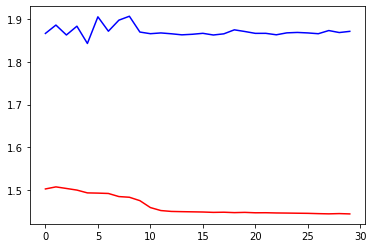

In [69]:
plot(LOSS, LOSS_V)

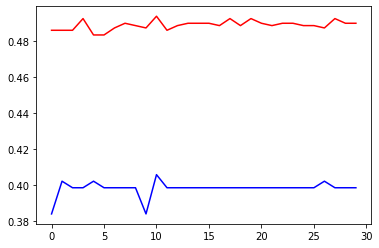

In [70]:
plot(ACC, ACC_V)

## Evaluate Top-1, Top-3 Accuracy on Test Set + Confusion Matrices

In [39]:
model = torch.load(f"./model_ckpts/triplenet_finetune_epochs_{num_epochs}.dat")
model = gpu(model)

In [71]:
def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    batches = test_dataloader
    with torch.no_grad():
        for x, y in tqdm(batches):
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            _, preds = torch.max(aggregated_scores, 1)
            # _, preds = torch.max(scores, 1)
            total += preds.size(0)
            correct += (preds == y).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

  0%|          | 0/154 [00:00<?, ?it/s]

Top 1 Accuracy of the network on the all test images: 40.91 %


In [72]:
def compute_top_3_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for x, y in tqdm(test_dataloader):
            x, y = gpu(x.squeeze(dim=0)), gpu(y)
            scores = model(x)
            aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
            _, preds = torch.topk(aggregated_scores, 3, dim=1)
            # _, preds = torch.topk(scores, 3, dim=1)
            total += y.size(0)
            for i in range(preds.shape[0]):
                top_5_predictions = preds[i]
                label = y[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 3 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_3_accuracy(model)

  0%|          | 0/154 [00:00<?, ?it/s]

Top 3 Accuracy of the network on the all test images: 68.18 %


In [73]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for x, y in test_dataloader:
        x, y = gpu(x.squeeze(dim=0)), gpu(y)
        scores = model(x)
        aggregated_scores = torch.max(scores, 0, keepdim=True)[0]
        _, predicted = torch.max(aggregated_scores, 1)
        # _, predicted = torch.max(scores, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(y.cpu().numpy().tolist())

In [74]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[61  0  0  0  0  0  0  0]
 [21  1  0  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0]
 [18  0  0  0  0  0  0  0]
 [17  0  0  0  1  0  0  0]
 [10  0  0  0  0  0  0  0]
 [11  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0]]
61 61


<AxesSubplot:>

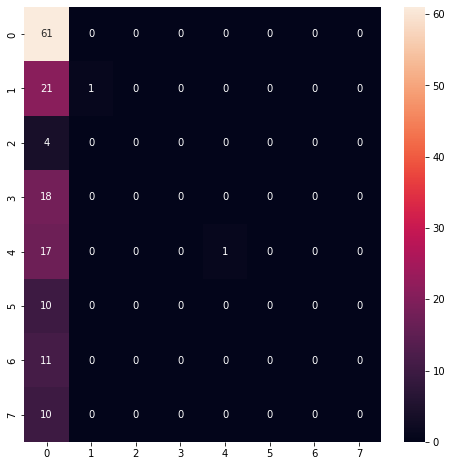

In [75]:
num_classes = 8
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(8)],
                  columns = [i for i in range(8)])
plt.figure(figsize = (8,8))
sns.heatmap(df_cm, annot=True)